In [37]:
#Import libraries:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

train = pd.read_csv('train_modified.csv')
target = 'Disbursed'
IDcol = 'ID'

In [38]:
#Functions for building the model
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['Disbursed'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.9856
AUC Score (Train): 0.862264
CV Score : Mean - 0.8318589 | Std - 0.008756969 | Min - 0.820805 | Max - 0.8438558


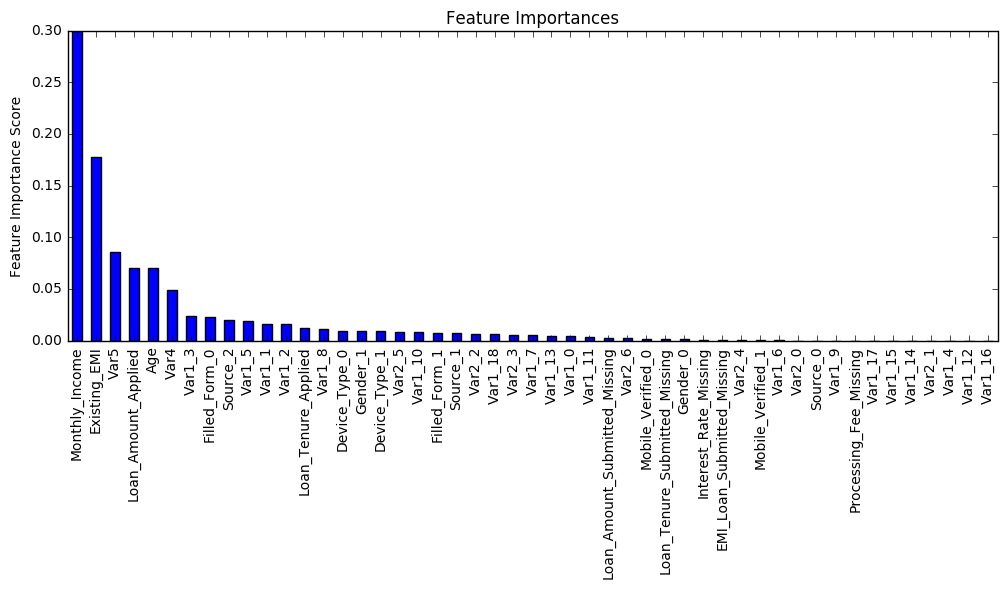

In [39]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, train, predictors)

In [ ]:
#Parameter Tuning
####################################################################################
#All about the Tree
#(1) Fix learning rate and number of estimators for tuning tree-based parameters
#Since We are required to use decision stumps, no need for this part

#initial estimates:

#min_samples_split = 500 : This should be ~0.5-1% of total values.
#min_samples_leaf = 50 : Can be selected based on intuition. This is just used for preventing overfitting and again a small value because of imbalanced classes.
#max_depth = 8 : Should be chosen (5-8) based on the number of observations and predictors. This has 87K rows and 49 columns so lets take 8 here.
#max_features = ‘sqrt’ : Its a general thumb-rule to start with square root.
#subsample = 0.8 : This is a commonly used used start value

#Choose all predictors except target & IDcols
#predictors = [x for x in train.columns if x not in [target, IDcol]]
#param_test1 = {'n_estimators':range(20,81,10)}
#gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
#param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
#gsearch1.fit(train[predictors],train[target])
#->n_estimators = 60

#gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

#(2)Tuning tree-specific parameters
#param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
#gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10), 
#param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
#gsearch2.fit(train[predictors],train[target])
#gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_
#->max_depth of 9 as optimum

#param_test3 = {'min_samples_split':range(1000,2100,200), 'min_samples_leaf':range(30,71,10)}
#gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9,max_features='sqrt', subsample=0.8, random_state=10), 
#param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
#gsearch3.fit(train[predictors],train[target])
#gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_
#->1200 for min_samples_split and 60 for min_samples_leaf

#param_test4 = {'max_features':range(7,20,2)}
#gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9, min_samples_split=1200, min_samples_leaf=60, subsample=0.8, random_state=10),
#param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
#gsearch4.fit(train[predictors],train[target])
#gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_
#max_features = 7

#Compared the tuned base model with the base model
#modelfit(gsearch3.best_estimator_, train, predictors)

In [33]:
#Parameter Tuning
####################################################################################
#(1)Tuning subsample and making models with lower learning rate
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9,min_samples_split=1200, min_samples_leaf=60, subsample=0.8, random_state=10,max_features=7),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_
#->0.85 as the optimum value for subsample

([mean: 0.79552, std: 0.01521, params: {'subsample': 0.6},
  mean: 0.79529, std: 0.01549, params: {'subsample': 0.7},
  mean: 0.78729, std: 0.01656, params: {'subsample': 0.75},
  mean: 0.79564, std: 0.01496, params: {'subsample': 0.8},
  mean: 0.79179, std: 0.01708, params: {'subsample': 0.85},
  mean: 0.79262, std: 0.01511, params: {'subsample': 0.9}],
 {'subsample': 0.8},
 0.79563621122971007)


Model Report
Accuracy : 0.9788
AUC Score (Train): 0.914252
CV Score : Mean - 0.7986675 | Std - 0.01596173 | Min - 0.7806103 | Max - 0.8262357


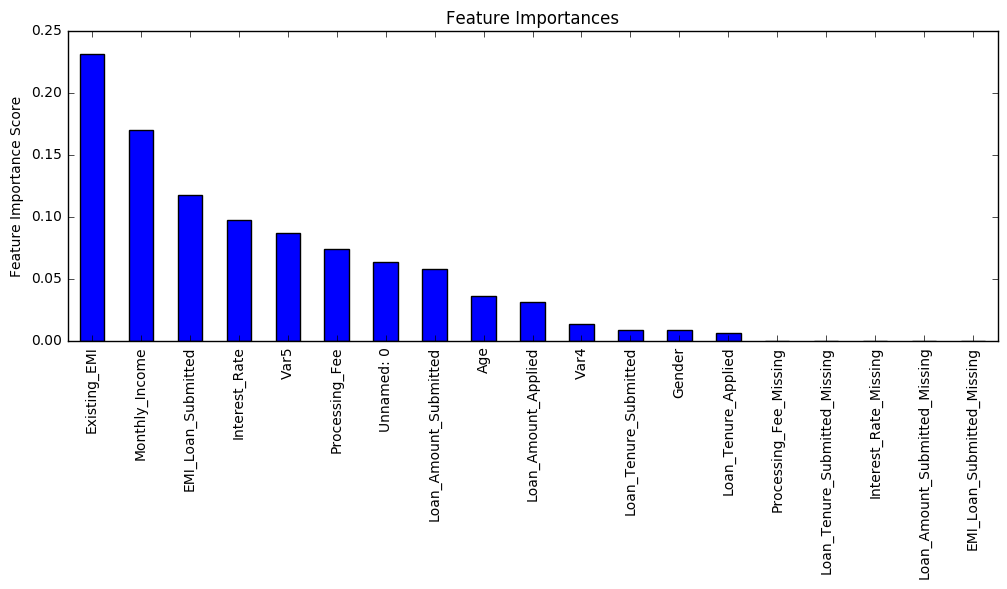

In [34]:
#Lets decrease the learning rate to half, i.e. 0.05 with twice (120) the number of trees.

predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=120,max_depth=9, min_samples_split=1200,min_samples_leaf=60, subsample=0.85, random_state=10, max_features=7)
modelfit(gbm_tuned_1, train, predictors)


Model Report
Accuracy : 0.9788
AUC Score (Train): 0.918292
CV Score : Mean - 0.7990706 | Std - 0.0149033 | Min - 0.7788968 | Max - 0.8253442


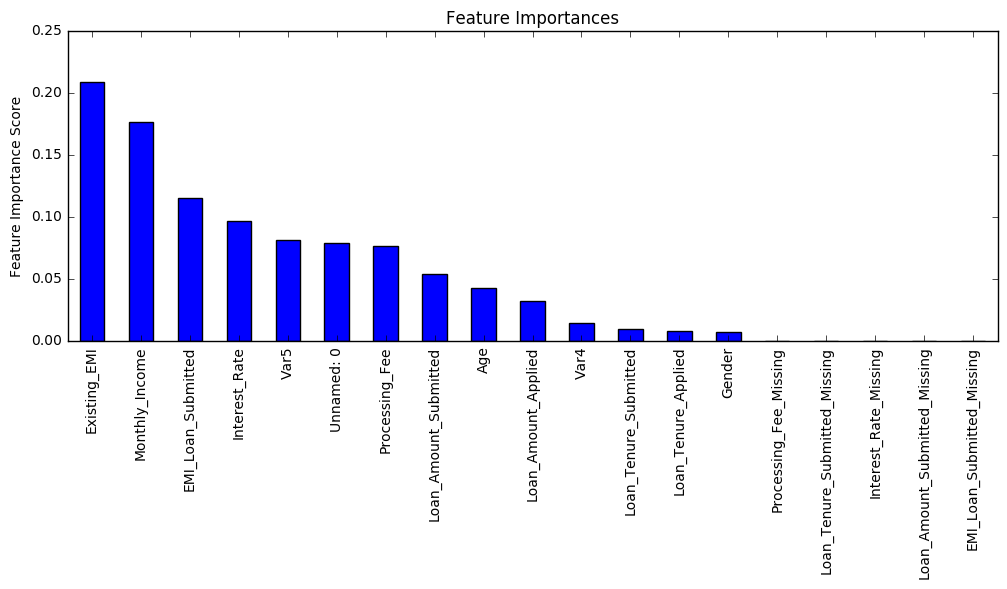

In [35]:
#Now lets reduce to one-tenth of the original value, i.e. 0.01 for 600 trees.

predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_2 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=600,max_depth=9, min_samples_split=1200,min_samples_leaf=60, subsample=0.85, random_state=10, max_features=7)
modelfit(gbm_tuned_2, train, predictors)


Model Report
Accuracy : 0.9788
AUC Score (Train): 0.916852


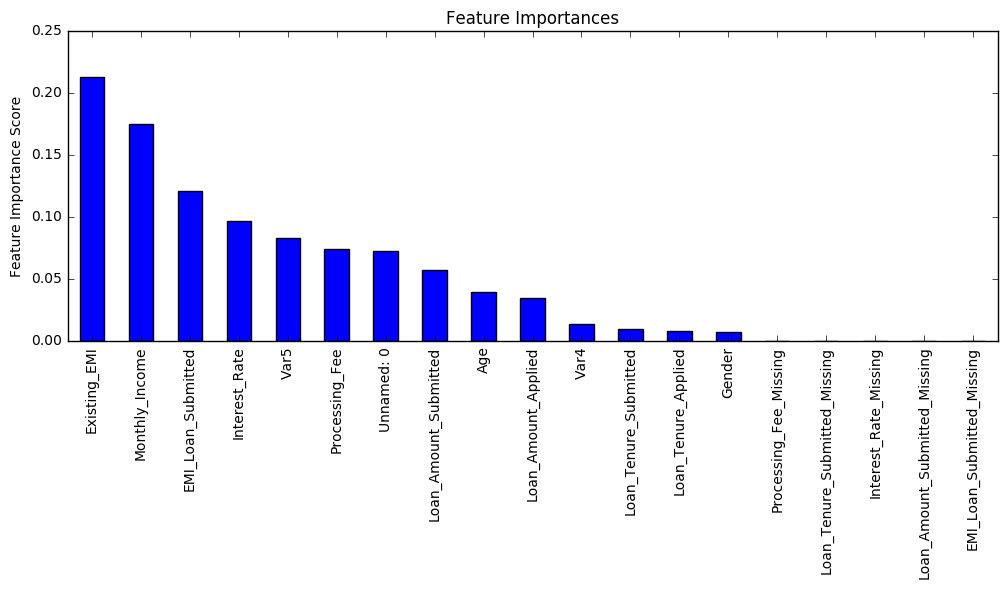

In [36]:
#Lets decrease to one-twentieth of the original value, i.e. 0.005 for 1200 trees.

predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_3 = GradientBoostingClassifier(learning_rate=0.005, n_estimators=1200,max_depth=9, min_samples_split=1200, min_samples_leaf=60, subsample=0.85, random_state=10, max_features=7,
warm_start=True)
modelfit(gbm_tuned_3, train, predictors, performCV=False)